# Imports

In [1]:
import h5py
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer

import cv2
import skimage
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Charger un tableau NumPy à partir du fichier HDF5
with h5py.File('processed_data.h5', 'r') as hf:
    X_txt = hf['text'][:]
    y = hf['label'][:]
    X_img = hf['img'][:]
    

# Train / test splits

In [3]:
X_train_txt, X_val_txt, X_train_img, X_val_img, y_train, y_val = train_test_split(X_txt, X_img, y, 
                                                                                  test_size=0.2, 
                                                                                  random_state=0, 
                                                                                  stratify=y)

In [4]:
from imblearn.under_sampling import RandomUnderSampler

# Créer un index pour les échantillons d'entraînement
indices_train = np.arange(len(X_train_txt))

# Appliquer RandomUnderSampler aux deux ensembles de données
undersample = RandomUnderSampler(random_state=0)
indices_resampled, _ = undersample.fit_resample(indices_train.reshape(-1, 1), y_train)

# Utiliser les indices resamplés pour sélectionner les échantillons correspondants dans X_train_txt et X_train_img
X_train_txt_resampled = X_train_txt[indices_resampled.flatten()]
X_train_img_resampled = X_train_img[indices_resampled.flatten()]
y_train_resampled = y_train[indices_resampled.flatten()]

# Vérifier les nouvelles distributions de classes
print('Classes échantillon undersampled :', dict(pd.Series(y_train[indices_resampled.flatten()]).value_counts()))


Classes échantillon undersampled : {10: 489, 1920: 489, 2705: 489, 2585: 489, 2583: 489, 2582: 489, 2522: 489, 2462: 489, 2403: 489, 2280: 489, 2220: 489, 2060: 489, 1940: 489, 1560: 489, 40: 489, 1320: 489, 1302: 489, 1301: 489, 1300: 489, 1281: 489, 1280: 489, 1180: 489, 1160: 489, 1140: 489, 60: 489, 50: 489, 2905: 489}


# Preprocessing

## Images Preprocessing

In [5]:
class GrayScaleConverter(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        #return np.array([skimage.color.rgb2gray(img) for img in X])
        return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]).astype(int)


In [6]:
class LaplacianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, ddepth=cv2.CV_64F):
        self.ddepth = ddepth
    
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        laplacian_images = []
        for image in X:
            # Appliquer le filtre Laplacien
            laplacian_image = cv2.Laplacian(np.uint8(image), self.ddepth)
            
            # Convertir l'image en 3 canaux si nécessaire
            if len(image.shape) == 3:
                laplacian_image = cv2.cvtColor(laplacian_image, cv2.COLOR_GRAY2BGR)
            
            laplacian_images.append(laplacian_image)
            
        return np.array(laplacian_images)


In [7]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(14,14),
                 cells_per_block=(2,2), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])
            

In [8]:
class HSVHistogram(BaseEstimator, TransformerMixin):
    def __init__(self, bins=256):
        self.bins = bins
    
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        histograms = []
        for image in X:
            
            # Assurez-vous que l'image est en format flottant
            image = image.astype(np.float32)

            # Normaliser l'image pour obtenir des valeurs entre 0 et 1
            image /= 255.0

            # Diviser l'image en canaux de couleur
            channels = cv2.split(image)

            # Initialiser un histogramme vide pour chaque canal de couleur
            hist = []

            # Calculer l'histogramme pour chaque canal de couleur
            for channel in channels:
                hist_channel, _ = np.histogram(channel, bins=256, range=(0, 1))
                hist.append(hist_channel)

            # Concaténer les histogrammes de chaque canal pour obtenir l'histogramme global
            hist = np.concatenate(hist)
            histograms.append(hist)
            
        return np.array(histograms).astype(int)


In [9]:
# 1. Image filters processing

processor_gray = GrayScaleConverter()
X_train_gray = processor_gray.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3))
X_val_gray = processor_gray.transform(X_val_img.reshape(-1, 100, 100, 3))

processor_hog = HogTransformer()
X_train_hog = processor_hog.fit_transform(X_train_gray)
X_val_hog = processor_hog.transform(X_val_gray)

processor_lap = LaplacianFilter()
X_train_laplacian = processor_lap.fit_transform(X_train_gray)
X_val_laplacian = processor_lap.transform(X_val_gray)

processor_hsv = HSVHistogram()
X_train_hsv = processor_hsv.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3))
X_val_hsv = processor_hsv.transform(X_val_img.reshape(-1, 100, 100, 3))


In [10]:
# 2. Réduction de dimension avec UMAP
umap_model = UMAP(n_components=500)
X_train_img_reduced = umap_model.fit_transform(X_train_gray.reshape(-1, 10000))
X_val_img_reduced = umap_model.transform(X_val_gray.reshape(-1, 10000))


In [11]:
# (alternative : UMAP Laplacien)
X_train_img_lap_reduced = umap_model.fit_transform(X_train_laplacian.reshape(-1, 10000))
X_val_img_lap_reduced = umap_model.transform(X_val_laplacian.reshape(-1, 10000))


In [12]:
# 3. on combine les features images avec les meilleurs features sélectionnés
X_train_img_hsvhog = np.concatenate((X_train_hog, X_train_hsv), axis=1)
X_val_img_hsvhog = np.concatenate((X_val_hog, X_val_hsv), axis=1)


# Modèles

# Filtered Images with Random Forest Models



In [13]:
#grayscale

In [14]:
%%time
rf_img = RandomForestClassifier(random_state=0, n_estimators=500)
rf_img.fit(X_train_img_reduced, y_train_resampled)
print(f"accuracy : {rf_img.score(X_val_img_reduced, y_val)}\n")

accuracy : 0.17067785383086775

CPU times: total: 4min 27s
Wall time: 4min 27s


In [15]:
#hsv

In [16]:
%%time
rf_img_hsv = RandomForestClassifier(random_state=0, n_estimators=500)
rf_img_hsv.fit(X_train_hsv, y_train_resampled)
print(f"accuracy : {rf_img_hsv.score(X_val_hsv, y_val)}\n")

accuracy : 0.26444395377934793

CPU times: total: 2min 11s
Wall time: 2min 11s


In [17]:
y_pred_hsv = rf_img_hsv.predict(X_val_hsv)

In [18]:
# Générer le rapport de classification
report = classification_report(y_val, y_pred_hsv)

# Afficher le rapport
print(report)

              precision    recall  f1-score   support

          10       0.31      0.26      0.28       499
          40       0.22      0.25      0.23       401
          50       0.12      0.29      0.17       269
          60       0.08      0.40      0.14       133
        1140       0.16      0.07      0.09       427
        1160       0.33      0.46      0.39       632
        1180       0.09      0.20      0.13       122
        1280       0.14      0.02      0.03       779
        1281       0.18      0.06      0.09       331
        1300       0.33      0.26      0.29       807
        1301       0.09      0.23      0.13       129
        1302       0.16      0.19      0.18       399
        1320       0.26      0.21      0.23       519
        1560       0.31      0.17      0.22       812
        1920       0.41      0.46      0.43       689
        1940       0.09      0.51      0.15       128
        2060       0.33      0.15      0.21       799
        2220       0.06    

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def conf_mat_print(y_pred):
    
    cm = confusion_matrix(y_val, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y_val)
    plt.figure(figsize=(15, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', 
                xticklabels=labels, yticklabels=labels)

    plt.title('Matrice de confusion - normalisation horizontale (%)')
    plt.xlabel('Classes prédites')
    plt.ylabel('Classes réelles')

    # Rotation des étiquettes des axes pour éviter les chevauchements
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Ajustement de l'espacement pour que tout soit bien visible
    plt.tight_layout()

    plt.show()

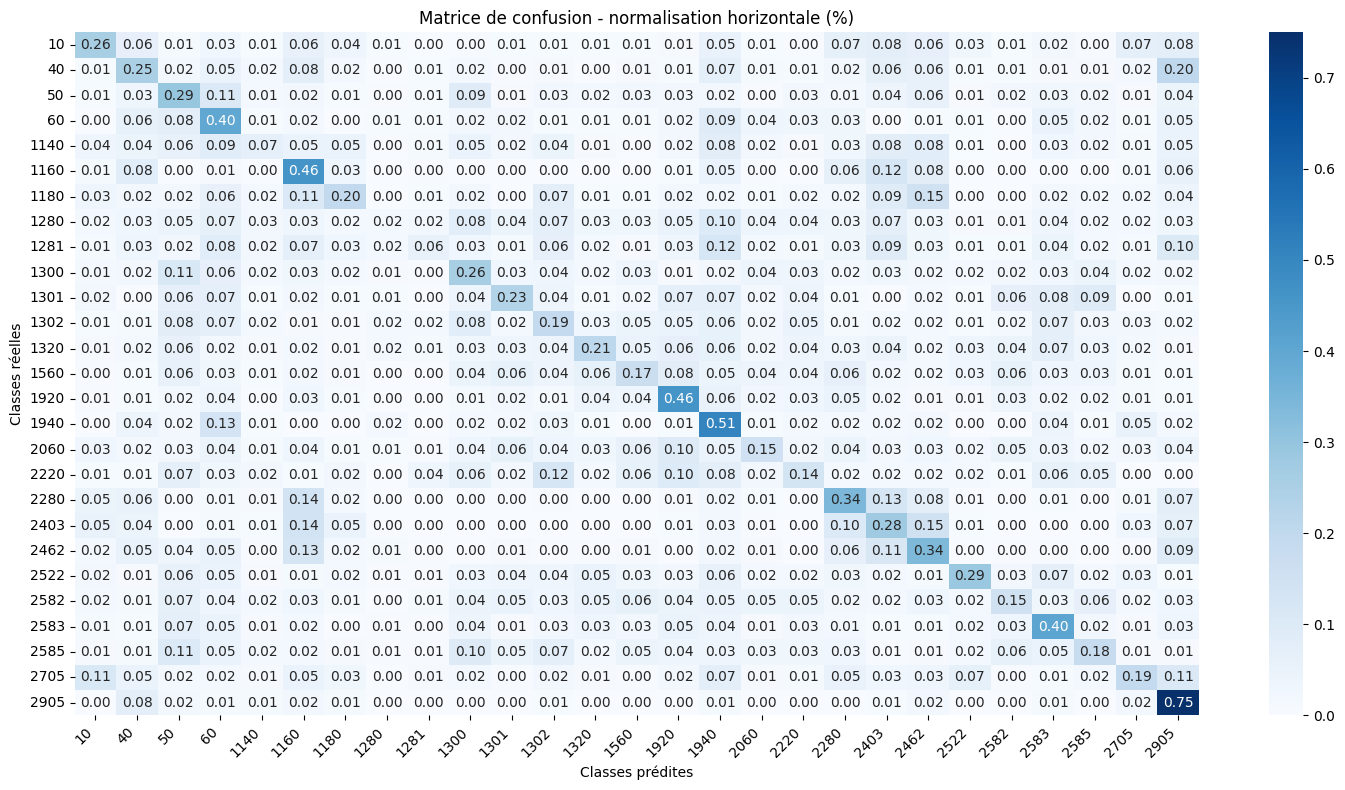

In [22]:
conf_mat_print(y_pred_hsv)

In [23]:
#hog

In [24]:
%%time
rf_img_hog = RandomForestClassifier(random_state=0, n_estimators=500)
rf_img_hog.fit(X_train_hog, y_train_resampled)
print(f"accuracy : {rf_img_hog.score(X_val_hog, y_val)}\n")

accuracy : 0.32656215500110397

CPU times: total: 6min 2s
Wall time: 6min 3s


In [25]:
y_pred_hog = rf_img_hog.predict(X_val_hog)

In [26]:
# Générer le rapport de classification
report = classification_report(y_val, y_pred_hog)

# Afficher le rapport
print(report)

              precision    recall  f1-score   support

          10       0.29      0.33      0.31       499
          40       0.29      0.19      0.23       401
          50       0.15      0.22      0.18       269
          60       0.11      0.34      0.16       133
        1140       0.31      0.22      0.26       427
        1160       0.56      0.73      0.63       632
        1180       0.21      0.15      0.17       122
        1280       0.22      0.06      0.09       779
        1281       0.15      0.07      0.10       331
        1300       0.36      0.19      0.25       807
        1301       0.16      0.43      0.23       129
        1302       0.22      0.20      0.21       399
        1320       0.28      0.18      0.22       519
        1560       0.48      0.22      0.30       812
        1920       0.65      0.65      0.65       689
        1940       0.13      0.46      0.21       128
        2060       0.25      0.28      0.27       799
        2220       0.05    

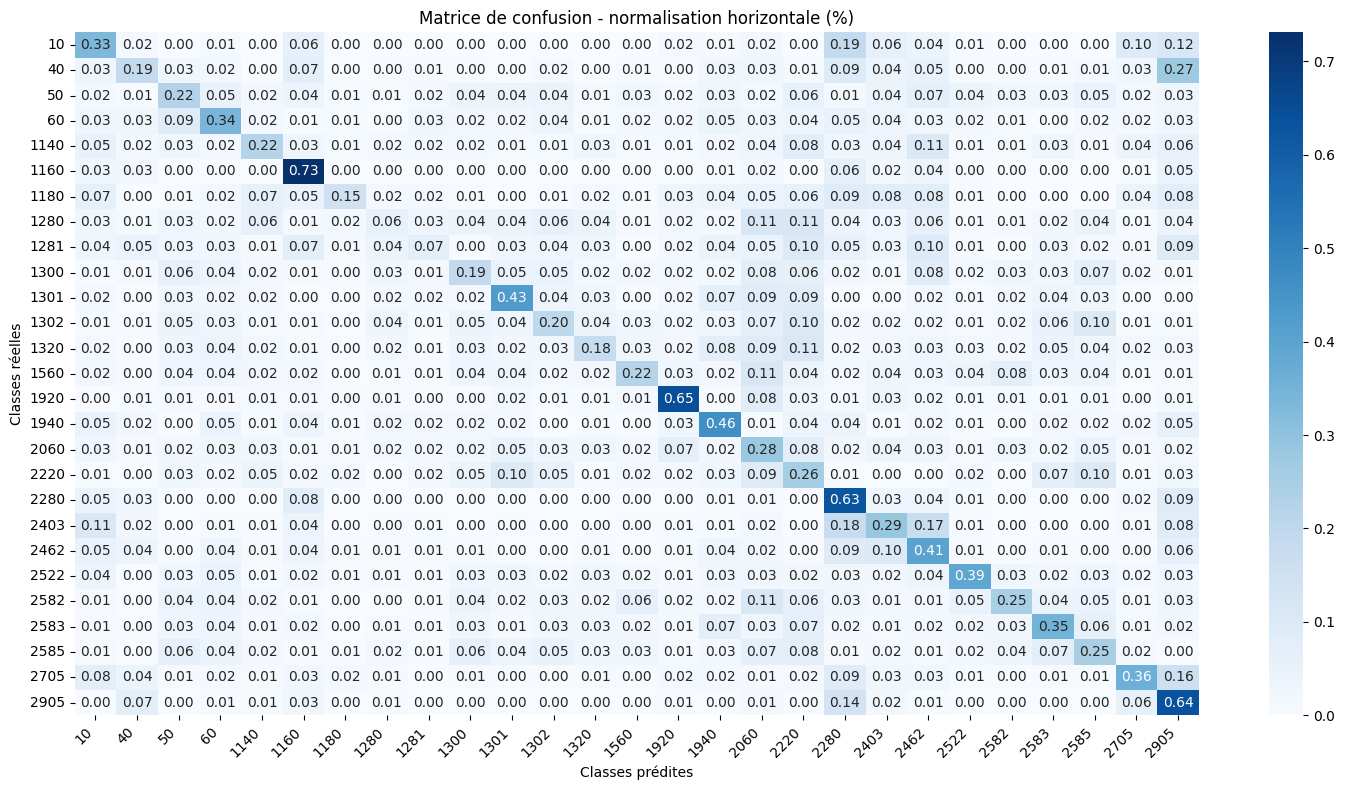

In [27]:
conf_mat_print(y_pred_hog)

In [28]:
#laplacian

In [29]:
%%time
rf_img_lap = RandomForestClassifier(random_state=0, n_estimators=500)
rf_img_lap.fit(X_train_img_lap_reduced, y_train_resampled)
print(f"accuracy : {rf_img_lap.score(X_val_img_lap_reduced, y_val)}\n")

accuracy : 0.06248620004415986

CPU times: total: 3min 32s
Wall time: 3min 32s


In [30]:
y_pred_lap = rf_img_lap.predict(X_val_img_lap_reduced)

In [31]:
# Générer le rapport de classification
report = classification_report(y_val, y_pred_lap)

# Afficher le rapport
print(report)

              precision    recall  f1-score   support

          10       0.28      0.06      0.10       499
          40       0.04      0.00      0.00       401
          50       0.02      0.78      0.04       269
          60       0.50      0.02      0.03       133
        1140       0.04      0.00      0.00       427
        1160       0.11      0.36      0.17       632
        1180       0.00      0.00      0.00       122
        1280       0.20      0.00      0.01       779
        1281       0.00      0.00      0.00       331
        1300       0.70      0.02      0.04       807
        1301       0.16      0.07      0.10       129
        1302       0.00      0.00      0.00       399
        1320       0.23      0.01      0.01       519
        1560       0.92      0.01      0.03       812
        1920       0.20      0.01      0.03       689
        1940       0.08      0.01      0.01       128
        2060       0.17      0.00      0.01       799
        2220       0.07    

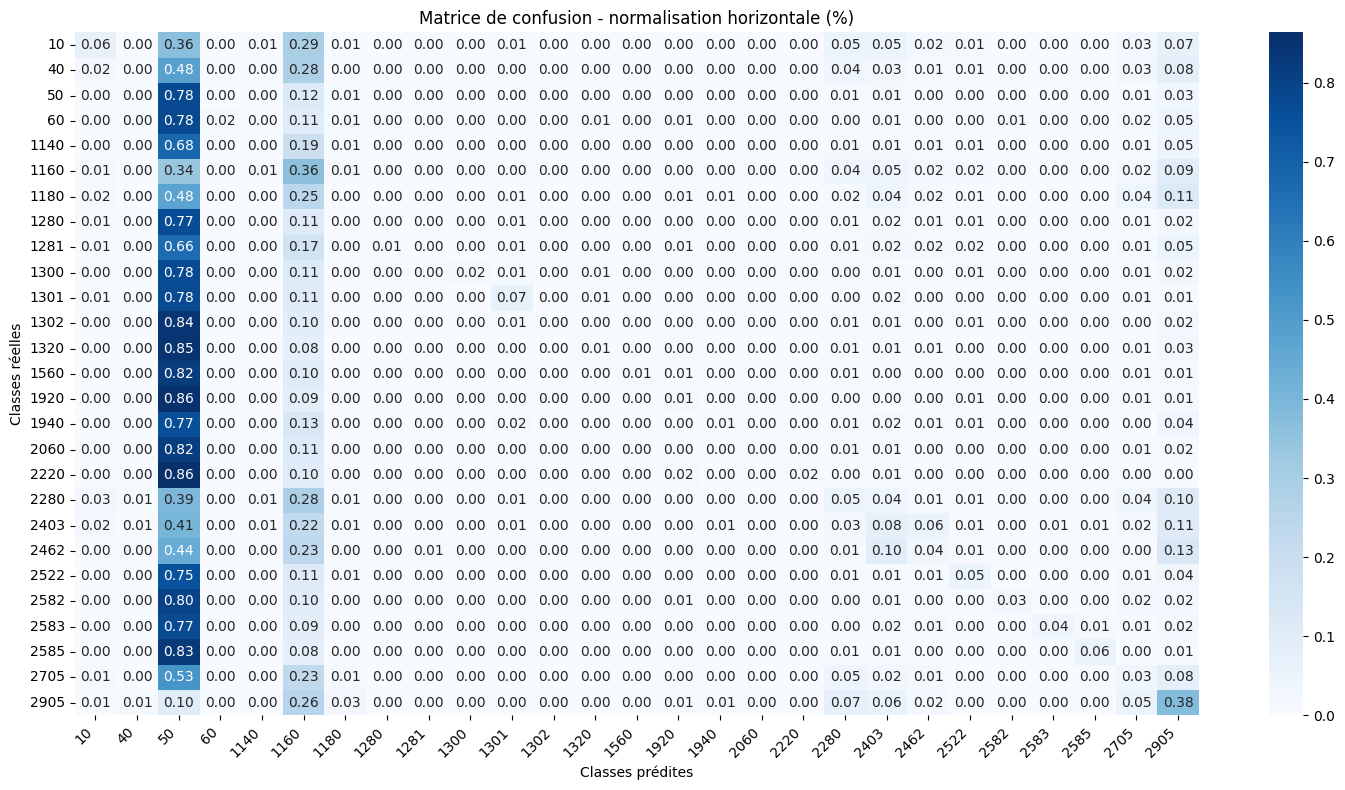

In [32]:
conf_mat_print(y_pred_lap)

In [33]:
#hog+hsv

In [34]:
%%time
rf_img_hsvhog = RandomForestClassifier(random_state=0, n_estimators=500)
rf_img_hsvhog.fit(X_train_img_hsvhog, y_train_resampled)
print(f"accuracy : {rf_img_hsvhog.score(X_val_img_hsvhog, y_val)}\n")

accuracy : 0.3392213144917936

CPU times: total: 5min 55s
Wall time: 5min 55s


In [35]:
y_pred_hsvhog = rf_img_hsvhog.predict(X_val_img_hsvhog)

In [36]:
# Générer le rapport de classification
report = classification_report(y_val, y_pred_hsvhog)

# Afficher le rapport
print(report)

              precision    recall  f1-score   support

          10       0.34      0.35      0.34       499
          40       0.26      0.26      0.26       401
          50       0.14      0.32      0.20       269
          60       0.12      0.45      0.19       133
        1140       0.37      0.14      0.20       427
        1160       0.59      0.75      0.66       632
        1180       0.15      0.20      0.17       122
        1280       0.21      0.04      0.07       779
        1281       0.14      0.07      0.10       331
        1300       0.38      0.26      0.31       807
        1301       0.16      0.38      0.22       129
        1302       0.17      0.16      0.17       399
        1320       0.26      0.25      0.25       519
        1560       0.38      0.22      0.28       812
        1920       0.59      0.66      0.62       689
        1940       0.12      0.58      0.20       128
        2060       0.35      0.25      0.29       799
        2220       0.06    

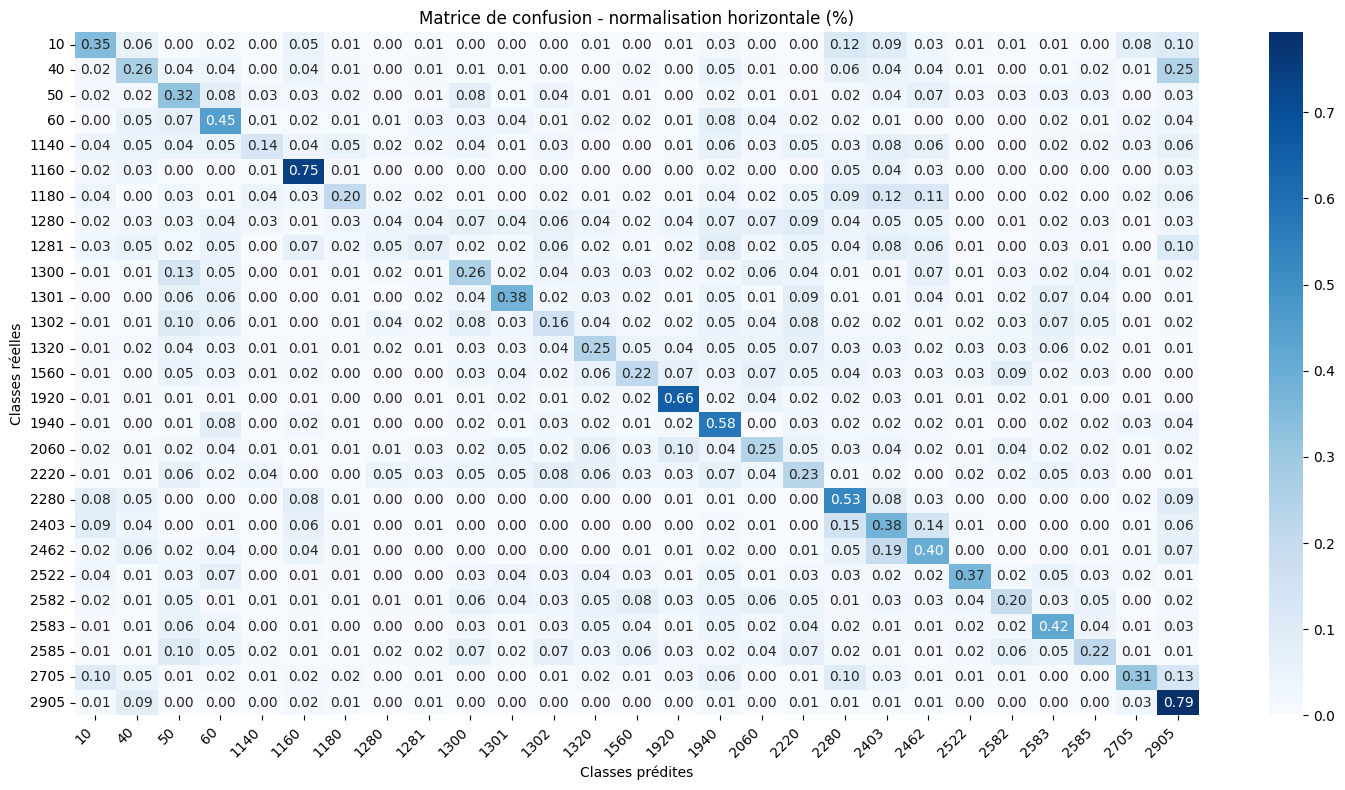

In [37]:
conf_mat_print(y_pred_hsvhog)